In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import seaborn as sns
import missingno as msno
import copy
import datetime as dt
from matplotlib.font_manager import FontProperties
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
plt.rcParams['font.family'] = 'KaiTi'
plt.rcParams['figure.facecolor'] = 'w'
warnings.filterwarnings('ignore')


In [2]:
# 导入数据
data1 = pd.read_excel("2018-01-03广东省-广州市-全区县-气象资料数据.xls")
#data1
data2 = pd.read_excel("2018-01-03广州市51个环保监测点.xlsx")
#data2
weather_data = copy.deepcopy(data1.iloc[:,6:-3].drop_duplicates(keep="first"))
weather_data["监测时间"] = weather_data["监测时间"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
air_data = copy.deepcopy(data2)
# 左连接两表
data = pd.merge(air_data, weather_data, how="left", sort=True, left_on="日期", right_on="监测时间")

# 删除全空列和无用列
del data["日照小时数(小时/日)"]
del data["监测时间"]
del data["最低气压(hpa)"]
del data["国控点名称"]

# 调整顺序，将pm2.5和pm10放到最后
order = ['日期', '测点编号', '测点名称', 'SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10', 'PM2.5']
data = data[order]
data.dropna(axis=0, how="any", inplace=True)
data.shape

del data["测点名称"]
del data["日期"]

data_ = data.iloc[:,:]
data_

,测点编号,SO2,NO2,CO,臭氧日最大8小时均值,臭氧日最大1小时,平均气压(hpa),最高气压(hpa),平均温度(℃),最高温度(℃),最低温度(℃),平均相对湿度(%),最大湿度(%),最小湿度(%),降水量(mm),日平均风速(m/s),PM10,PM2.5
0,51,14.0,62.0,1.0,63.0,77.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,118.0,85.0
1,50,24.0,62.0,1.0,62.0,72.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,115.0,90.0
2,49,22.0,66.0,1.4,89.0,106.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,138.0,87.0
3,48,17.0,65.0,1.4,91.0,103.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,112.0,76.0
4,47,15.0,72.0,1.1,69.0,86.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,109.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4585,5,12.0,72.0,0.9,173.0,228.0,1007.1,1009.6,22.6,29.2,18.8,82,98,49,0.0,1.5,63.0,38.0
4586,4,14.0,67.0,0.9,182.0,257.0,1007.1,1009.6,22.6,29.2,18.8,82,98,49,0.0,1.5,56.0,35.0
4587,3,16.0,71.0,0.5,177.0,243.0,1007.1,1009.6,22.6,29.2,18.8,82,98,49,0.0,1.5,76.0,41.0
4588,2,17.0,61.0,0.7,189.0,247.0,1007.1,1009.6,22.6,29.2,18.8,82,98,49,0.0,1.5,67.0,33.0


In [3]:
# 对PM2.5数据取log
data_.iloc[:,-1] = np.log(data_.iloc[:,-1])
data_

,测点编号,SO2,NO2,CO,臭氧日最大8小时均值,臭氧日最大1小时,平均气压(hpa),最高气压(hpa),平均温度(℃),最高温度(℃),最低温度(℃),平均相对湿度(%),最大湿度(%),最小湿度(%),降水量(mm),日平均风速(m/s),PM10,PM2.5
0,51,14.0,62.0,1.0,63.0,77.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,118.0,4.442651
1,50,24.0,62.0,1.0,62.0,72.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,115.0,4.499810
2,49,22.0,66.0,1.4,89.0,106.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,138.0,4.465908
3,48,17.0,65.0,1.4,91.0,103.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,112.0,4.330733
4,47,15.0,72.0,1.1,69.0,86.0,1012.7,1014.9,14.1,19.4,8.9,71,87,51,0.0,1.7,109.0,4.262680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4585,5,12.0,72.0,0.9,173.0,228.0,1007.1,1009.6,22.6,29.2,18.8,82,98,49,0.0,1.5,63.0,3.637586
4586,4,14.0,67.0,0.9,182.0,257.0,1007.1,1009.6,22.6,29.2,18.8,82,98,49,0.0,1.5,56.0,3.555348
4587,3,16.0,71.0,0.5,177.0,243.0,1007.1,1009.6,22.6,29.2,18.8,82,98,49,0.0,1.5,76.0,3.713572
4588,2,17.0,61.0,0.7,189.0,247.0,1007.1,1009.6,22.6,29.2,18.8,82,98,49,0.0,1.5,67.0,3.496508


In [4]:
# 特征筛选可视化
def get_sfs_feature_importance(model, feature_importance, X_t, k_features=5):
    sfs = SFS(model, k_features=k_features, forward=True, floating=False, scoring='r2', cv=0)
    sfs.fit(X_t, y_train)
    fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
    plt.grid()
    plt.show()
    print("Deleted features:")
    print(feature_importance.loc[list(set(feature_importance.index).difference(set(sfs.k_feature_names_)))])
    print("\nKeeped features:")
    print(feature_importance.loc[list(sfs.k_feature_names_)])

# 训练集，验证集

In [5]:
from sklearn.model_selection import train_test_split
data_columns = data.columns
data_.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
X_train,X_test,y_train,y_test =train_test_split(data_.iloc[:,:-1],data_.iloc[:,-1],test_size=0.1)

# LightGBM

In [6]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

        column  importance
0         站点编号         339
13     最小湿度(%)         191
16        PM10         173
2          NO2         166
10     最低温度(℃)         164
9      最高温度(℃)         160
8      平均温度(℃)         153
4   臭氧日最大8小时均值         137
6    平均气压(hpa)         121
1          SO2         120
3           CO         119
15  日平均风速(m/s)         109
11   平均相对湿度(%)         106
5     臭氧日最大1小时         104
7    最高气压(hpa)          97
12     最大湿度(%)          95
14     降水量(mm)          54


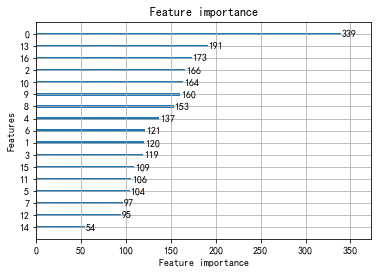

In [7]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=15,
                              learning_rate=0.1, n_estimators=172, max_depth=9, 
                              metric='rmse', bagging_fraction = 0.01, feature_fraction = 0.2,
                              min_child_samples=18, min_child_weight=0.001)
model_lgb.fit(X_train, y_train)
feature_name = np.array(['站点编号','SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10'])
fea_imp_lgb = pd.DataFrame({
        'column': feature_name,
        'importance': model_lgb.feature_importances_ ,
    }).sort_values(by='importance')[::-1]
print(fea_imp_lgb)
plt.rcParams['figure.facecolor'] = 'w'
lgb.plot_importance(model_lgb)

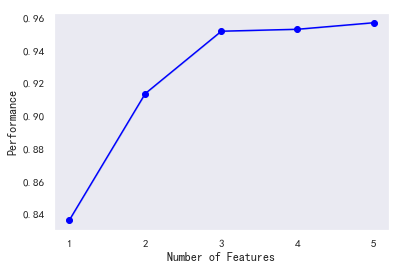

Deleted features:
        column  importance
1          SO2         120
2          NO2         166
3           CO         119
4   臭氧日最大8小时均值         137
5     臭氧日最大1小时         104
6    平均气压(hpa)         121
7    最高气压(hpa)          97
8      平均温度(℃)         153
11   平均相对湿度(%)         106
12     最大湿度(%)          95
14     降水量(mm)          54
15  日平均风速(m/s)         109

Keeped features:
     column  importance
0      站点编号         339
9   最高温度(℃)         160
10  最低温度(℃)         164
13  最小湿度(%)         191
16     PM10         173


In [37]:
get_sfs_feature_importance(lgb.LGBMRegressor(objective='regression',num_leaves=15,
                              learning_rate=0.1, n_estimators=172, max_depth=9, 
                              metric='rmse', bagging_fraction = 0.01, feature_fraction = 0.2,
                              min_child_samples=18, min_child_weight=0.001), fea_imp_lgb,X_train)

# XGBoost

        column  importance
14     降水量(mm)    0.447766
16        PM10    0.282763
15  日平均风速(m/s)    0.055124
13     最小湿度(%)    0.049310
11   平均相对湿度(%)    0.027260
3           CO    0.022800
6    平均气压(hpa)    0.019230
10     最低温度(℃)    0.017423
8      平均温度(℃)    0.014374
12     最大湿度(%)    0.013725
9      最高温度(℃)    0.011592
0         站点编号    0.009686
7    最高气压(hpa)    0.008665
1          SO2    0.007135
2          NO2    0.007031
5     臭氧日最大1小时    0.003288
4   臭氧日最大8小时均值    0.002830


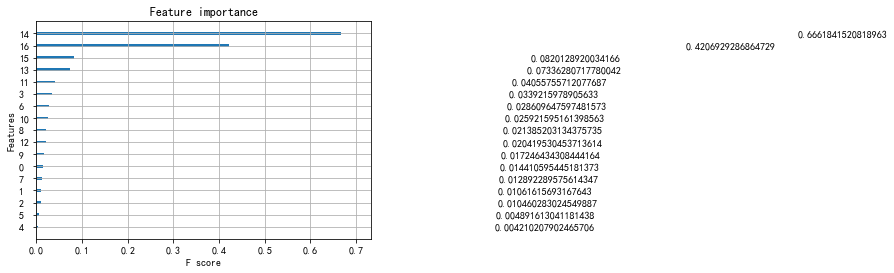

In [8]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
model_xgb = xgb.XGBRegressor(max_depth=10,
            learning_rate=0.1,
            n_estimators=1000,
            silent=True,
            objective='reg:squarederror',
            n_jobs=12,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            missing=None)
model_xgb.fit(X_train, y_train)
feature_name = np.array(['站点编号','SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10'])
fea_imp_xgb = pd.DataFrame({
        'column': feature_name,
        'importance': model_xgb.feature_importances_ ,
    }).sort_values(by='importance')[::-1]
print(fea_imp_xgb)
xgb.plot_importance(model_xgb,importance_type='gain')

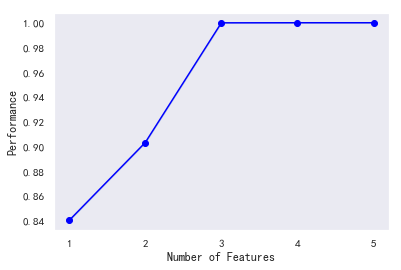

Deleted features:
        column  importance
1          SO2    0.007135
3           CO    0.022800
4   臭氧日最大8小时均值    0.002830
6    平均气压(hpa)    0.019230
7    最高气压(hpa)    0.008665
8      平均温度(℃)    0.014374
9      最高温度(℃)    0.011592
11   平均相对湿度(%)    0.027260
12     最大湿度(%)    0.013725
13     最小湿度(%)    0.049310
14     降水量(mm)    0.447766
15  日平均风速(m/s)    0.055124

Keeped features:
      column  importance
0       站点编号    0.009686
2        NO2    0.007031
5   臭氧日最大1小时    0.003288
10   最低温度(℃)    0.017423
16      PM10    0.282763


In [38]:
get_sfs_feature_importance(xgb.XGBRegressor(max_depth=10,
            learning_rate=0.1,
            n_estimators=1000,
            silent=True,
            objective='reg:squarederror',
            n_jobs=12,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            missing=None), fea_imp_xgb,X_train)

# Catboost

In [9]:
import catboost as cb
model_cb = cb.CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.1, loss_function='RMSE',
                               silent=True)
model_cb.fit(X_train, y_train, cat_features=[0])
feature_name = np.array(['站点编号','SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10'])
fea_imp_cb = pd.DataFrame({
        'column': feature_name,
        'importance': model_cb.feature_importances_ ,
    }).sort_values(by='importance')[::-1]
print(fea_imp_cb)
#cb.plot_importance(model_cb)

        column  importance
16        PM10   45.110239
0         站点编号   10.029704
3           CO    4.553828
13     最小湿度(%)    4.367167
2          NO2    4.047264
6    平均气压(hpa)    3.928571
15  日平均风速(m/s)    3.860620
7    最高气压(hpa)    3.556108
1          SO2    3.358375
12     最大湿度(%)    2.893354
9      最高温度(℃)    2.438112
10     最低温度(℃)    2.343264
8      平均温度(℃)    2.232074
14     降水量(mm)    2.139096
5     臭氧日最大1小时    1.822713
4   臭氧日最大8小时均值    1.715900
11   平均相对湿度(%)    1.603609


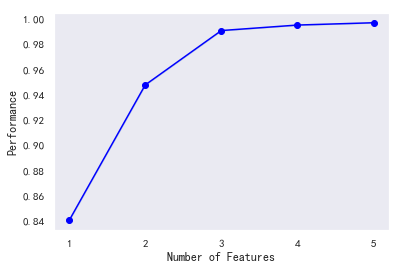

Deleted features:
        column  importance
1          SO2    3.358375
2          NO2    4.047264
5     臭氧日最大1小时    1.822713
6    平均气压(hpa)    3.928571
7    最高气压(hpa)    3.556108
8      平均温度(℃)    2.232074
9      最高温度(℃)    2.438112
11   平均相对湿度(%)    1.603609
12     最大湿度(%)    2.893354
13     最小湿度(%)    4.367167
14     降水量(mm)    2.139096
15  日平均风速(m/s)    3.860620

Keeped features:
        column  importance
0         站点编号   10.029704
3           CO    4.553828
4   臭氧日最大8小时均值    1.715900
10     最低温度(℃)    2.343264
16        PM10   45.110239


In [39]:
get_sfs_feature_importance(cb.CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.1, loss_function='RMSE',
                               silent=True), fea_imp_cb, X_train)

# Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
model_rdf = RandomForestRegressor()
model_rdf.fit(X_train, y_train)
feature_name = np.array(['站点编号','SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10'])
fea_imp_rdf = pd.DataFrame({
        'column': feature_name,
        'importance': model_rdf.feature_importances_ ,
    }).sort_values(by='importance')[::-1]
print(fea_imp_rdf)
#RandomForestRegressor.plot_importance(clf)

        column  importance
16        PM10    0.834423
0         站点编号    0.030967
3           CO    0.016706
15  日平均风速(m/s)    0.016483
2          NO2    0.015258
13     最小湿度(%)    0.013636
1          SO2    0.010977
9      最高温度(℃)    0.009441
4   臭氧日最大8小时均值    0.008717
5     臭氧日最大1小时    0.008678
6    平均气压(hpa)    0.006851
12     最大湿度(%)    0.005432
10     最低温度(℃)    0.005206
8      平均温度(℃)    0.005149
7    最高气压(hpa)    0.005024
11   平均相对湿度(%)    0.004732
14     降水量(mm)    0.002320


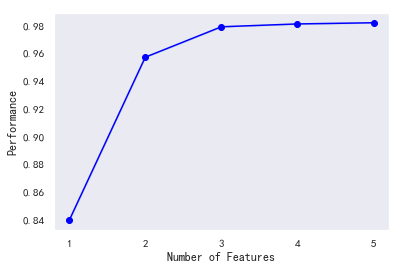

Deleted features:
        column  importance
1          SO2    0.010977
2          NO2    0.015258
3           CO    0.016706
4   臭氧日最大8小时均值    0.008717
5     臭氧日最大1小时    0.008678
6    平均气压(hpa)    0.006851
7    最高气压(hpa)    0.005024
9      最高温度(℃)    0.009441
10     最低温度(℃)    0.005206
11   平均相对湿度(%)    0.004732
14     降水量(mm)    0.002320
15  日平均风速(m/s)    0.016483

Keeped features:
     column  importance
0      站点编号    0.030967
8   平均温度(℃)    0.005149
12  最大湿度(%)    0.005432
13  最小湿度(%)    0.013636
16     PM10    0.834423


In [24]:
get_sfs_feature_importance(RandomForestRegressor(), fea_imp_rdf, X_train)

# normalization

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.530794,1.586620,0.670299,1.056830,-1.252743,-1.256633,-0.701352,-0.734207,0.077217,-0.163370,0.278378,0.583183,0.181311,0.761822,-0.296559,-0.394304,2.022195
1,-1.547120,0.363362,0.796103,-0.375136,0.172341,-0.013192,-0.188262,-0.260896,0.097476,0.537158,-0.334937,-1.357077,-0.710844,-1.425694,-0.296559,-0.492805,-0.251865
2,-0.869569,-0.510394,-0.870805,-0.661529,-1.296592,-1.291173,-0.654707,-0.711669,-0.753422,-1.416946,-0.149084,1.514507,0.738908,1.266634,4.917012,0.393703,-1.323548
3,-0.192019,1.936122,0.229983,-0.088743,-0.309995,0.021348,1.840775,1.722504,-1.199131,-0.624243,-1.691662,-1.279466,-0.041728,-1.593964,-0.296559,-0.492805,0.297046
4,1.366348,2.285624,-0.461941,0.484044,2.496324,1.938320,-0.864607,-0.779285,0.036698,0.795247,-0.409278,-0.115311,0.627389,-0.920882,-0.296559,-0.492805,1.211898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3929,-0.259774,-0.859896,0.229983,1.629617,-0.068827,0.124968,-0.701352,-0.734207,0.077217,-0.163370,0.278378,0.583183,0.181311,0.761822,-0.296559,-0.394304,1.002789
3930,1.298593,-1.034648,-0.336137,-0.375136,0.632753,0.297669,1.304363,1.316809,-0.854720,-0.126500,-1.357127,-0.658583,0.515869,-1.201333,-0.296559,-0.000300,-0.382558
3931,1.095328,-0.335643,0.009825,-0.947922,0.413509,0.228588,-0.188262,-0.260896,0.097476,0.537158,-0.334937,-1.357077,-0.710844,-1.425694,-0.296559,-0.492805,-0.278004
3932,1.569613,0.013859,-0.147430,0.197651,0.369660,0.107698,1.560908,1.587272,-1.685359,-1.066682,-2.007611,-2.133181,-1.156921,-1.593964,-0.296559,-0.098801,-0.121172


In [12]:
X_test_scaled = pd.DataFrame(scaler.transform(copy.deepcopy(X_test)))
X_test_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.682630,0.013859,-0.241783,-1.234316,0.040795,-0.134082,2.027353,1.925352,-1.685359,-2.062168,-1.096933,-2.754064,-4.390983,-1.481784,-0.296559,1.575713,0.323185
1,-1.614875,0.363362,0.324336,0.197651,0.523131,0.349479,-0.188262,-0.260896,0.097476,0.537158,-0.334937,-1.357077,-0.710844,-1.425694,-0.296559,-0.492805,-0.121172
2,-1.614875,0.363362,0.513043,-0.088743,0.873921,0.781229,0.884562,0.775881,-0.490049,0.315938,-1.152689,-0.813804,0.627389,-1.593964,-0.296559,-0.394304,-0.095033
3,-0.530794,0.013859,0.292885,-0.661529,0.391585,0.245858,-0.538096,-0.531360,1.090191,0.371243,1.319153,0.505572,0.515869,0.817912,-0.296559,-0.098801,0.375462
4,-0.598549,-1.558901,-0.524843,-0.661529,-1.274667,-1.308443,0.977851,0.933652,-2.313403,-2.854871,-1.654491,1.048845,0.627389,1.042273,0.892027,1.181710,-0.591667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,-0.801814,1.237117,-0.241783,-1.234316,-0.748483,-0.617642,-0.071650,-0.170741,-0.652125,-0.679548,-0.483619,0.039910,-0.599324,0.369191,-0.296559,-0.197302,-0.382558
434,0.214512,-1.558901,-0.115979,-0.088743,0.260038,0.107698,1.117785,1.294270,-0.469789,-0.642678,-0.186254,-1.434687,-2.160595,-0.640431,-0.296559,1.871216,0.349323
435,1.434103,-0.335643,0.261434,-0.375136,0.501206,0.660339,-0.164940,-0.193280,0.705261,0.592462,0.743009,-0.270532,-0.264766,-0.023440,-0.296559,-0.197302,-0.565528
436,0.553287,-0.510394,-0.399039,-0.661529,-0.573088,-0.721262,1.840775,1.812659,-1.259910,-1.251031,-1.004006,-0.969025,0.069792,-1.201333,-0.296559,0.098200,-0.591667


# Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
feature_name = np.array(['站点编号','SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10'])
fea_imp_lr = pd.DataFrame({
        'column': feature_name,
        'weight': np.abs(model_lr.coef_),
    }).sort_values(by='weight')[::-1]
print(fea_imp_lr)

        column    weight
16        PM10  0.468714
6    平均气压(hpa)  0.345830
9      最高温度(℃)  0.267431
7    最高气压(hpa)  0.181377
15  日平均风速(m/s)  0.154946
10     最低温度(℃)  0.142301
11   平均相对湿度(%)  0.111412
14     降水量(mm)  0.101367
13     最小湿度(%)  0.078454
0         站点编号  0.061391
2          NO2  0.050672
4   臭氧日最大8小时均值  0.038310
3           CO  0.026760
12     最大湿度(%)  0.021675
8      平均温度(℃)  0.003702
5     臭氧日最大1小时  0.001163
1          SO2  0.000280


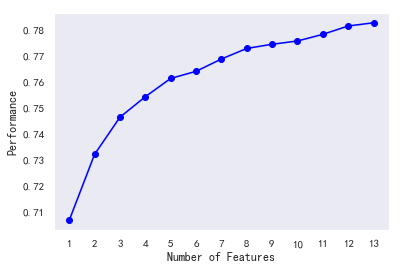

Deleted features:
      column    weight
8    平均温度(℃)  0.003702
1        SO2  0.000280
13   最小湿度(%)  0.078454
5   臭氧日最大1小时  0.001163

Keeped features:
        column    weight
0         站点编号  0.061391
2          NO2  0.050672
3           CO  0.026760
4   臭氧日最大8小时均值  0.038310
6    平均气压(hpa)  0.345830
7    最高气压(hpa)  0.181377
9      最高温度(℃)  0.267431
10     最低温度(℃)  0.142301
11   平均相对湿度(%)  0.111412
12     最大湿度(%)  0.021675
14     降水量(mm)  0.101367
15  日平均风速(m/s)  0.154946
16        PM10  0.468714


In [29]:
get_sfs_feature_importance(LinearRegression(), fea_imp_lr, X_train_scaled,13)

# Ridge Regression (L2)

In [14]:
from sklearn.linear_model import Ridge,RidgeCV
model_rd = RidgeCV()
model_rd.fit(X_train_scaled, y_train)
feature_name = np.array(['站点编号','SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10'])
fea_imp_rd = pd.DataFrame({
        'column': feature_name,
        'weight': np.abs(model_rd.coef_),
    }).sort_values(by='weight')[::-1]
print(fea_imp_rd)

        column    weight
16        PM10  0.468367
6    平均气压(hpa)  0.332978
9      最高温度(℃)  0.265366
7    最高气压(hpa)  0.169818
15  日平均风速(m/s)  0.153977
10     最低温度(℃)  0.139048
11   平均相对湿度(%)  0.109634
14     降水量(mm)  0.101057
13     最小湿度(%)  0.077585
0         站点编号  0.061350
2          NO2  0.050391
4   臭氧日最大8小时均值  0.038013
3           CO  0.026861
12     最大湿度(%)  0.020298
8      平均温度(℃)  0.001524
5     臭氧日最大1小时  0.001479
1          SO2  0.000350


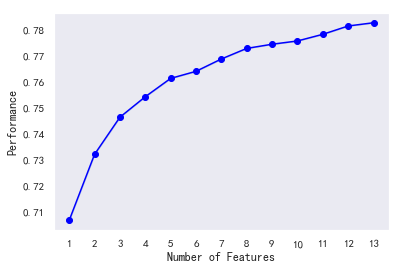

Deleted features:
      column    weight
8    平均温度(℃)  0.001524
1        SO2  0.000350
13   最小湿度(%)  0.077585
5   臭氧日最大1小时  0.001479

Keeped features:
        column    weight
0         站点编号  0.061350
2          NO2  0.050391
3           CO  0.026861
4   臭氧日最大8小时均值  0.038013
6    平均气压(hpa)  0.332978
7    最高气压(hpa)  0.169818
9      最高温度(℃)  0.265366
10     最低温度(℃)  0.139048
11   平均相对湿度(%)  0.109634
12     最大湿度(%)  0.020298
14     降水量(mm)  0.101057
15  日平均风速(m/s)  0.153977
16        PM10  0.468367


In [33]:
get_sfs_feature_importance(RidgeCV(), fea_imp_rd, X_train_scaled,13)

# Lasso Regression (L1)

In [15]:
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
model_ls = LassoLarsCV()
model_ls.fit(X_train_scaled, y_train)
feature_name = np.array(['站点编号','SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10'])
fea_imp_ls = pd.DataFrame({
        'column': feature_name,
        'weight': np.abs(model_ls.coef_),
    }).sort_values(by='weight')[::-1]
print(fea_imp_ls)

        column    weight
16        PM10  0.468375
6    平均气压(hpa)  0.314069
9      最高温度(℃)  0.260337
7    最高气压(hpa)  0.152800
15  日平均风速(m/s)  0.152567
10     最低温度(℃)  0.133826
11   平均相对湿度(%)  0.104747
14     降水量(mm)  0.100566
13     最小湿度(%)  0.076460
0         站点编号  0.061104
2          NO2  0.049592
4   臭氧日最大8小时均值  0.038900
3           CO  0.026434
12     最大湿度(%)  0.016487
5     臭氧日最大1小时  0.000360
1          SO2  0.000157
8      平均温度(℃)  0.000000


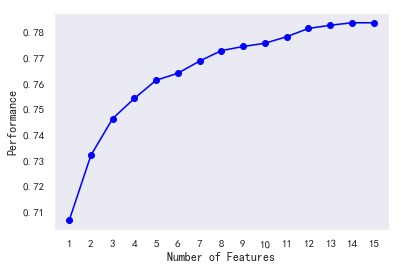

Deleted features:
     column   weight
8   平均温度(℃)  0.00000
5  臭氧日最大1小时  0.00036

Keeped features:
        column    weight
0         站点编号  0.061104
1          SO2  0.000157
2          NO2  0.049592
3           CO  0.026434
4   臭氧日最大8小时均值  0.038900
6    平均气压(hpa)  0.314069
7    最高气压(hpa)  0.152800
9      最高温度(℃)  0.260337
10     最低温度(℃)  0.133826
11   平均相对湿度(%)  0.104747
12     最大湿度(%)  0.016487
13     最小湿度(%)  0.076460
14     降水量(mm)  0.100566
15  日平均风速(m/s)  0.152567
16        PM10  0.468375


In [35]:
get_sfs_feature_importance(LassoLarsCV(), fea_imp_ls, X_train_scaled,15)

# Suport Vector Regressor

In [16]:
from sklearn.svm import SVR
model_svr = SVR(kernel="linear")
model_svr.fit(X_train_scaled, y_train)
feature_name = np.array(['站点编号','SO2', 'NO2', 'CO',
       '臭氧日最大8小时均值', '臭氧日最大1小时', '平均气压(hpa)', '最高气压(hpa)', '平均温度(℃)',
       '最高温度(℃)', '最低温度(℃)', '平均相对湿度(%)', '最大湿度(%)', '最小湿度(%)', '降水量(mm)',
       '日平均风速(m/s)', 'PM10'])
fea_imp_svr = pd.DataFrame({
        'column': feature_name,
        'weight': np.abs(model_svr.coef_.flatten()),
    }).sort_values(by='weight')[::-1]
print(fea_imp_svr)

        column    weight
16        PM10  0.455951
6    平均气压(hpa)  0.300555
9      最高温度(℃)  0.222758
7    最高气压(hpa)  0.156697
15  日平均风速(m/s)  0.147028
14     降水量(mm)  0.096531
10     最低温度(℃)  0.073037
11   平均相对湿度(%)  0.067852
0         站点编号  0.062859
2          NO2  0.052018
4   臭氧日最大8小时均值  0.051832
13     最小湿度(%)  0.046095
3           CO  0.035618
8      平均温度(℃)  0.018137
1          SO2  0.006437
5     臭氧日最大1小时  0.005656
12     最大湿度(%)  0.005206


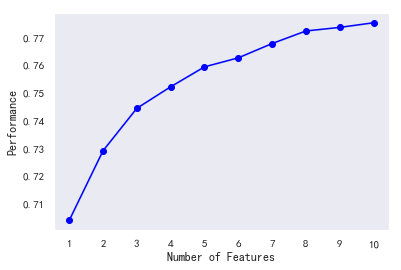

Deleted features:
       column    weight
1         SO2  0.006437
3          CO  0.035618
5    臭氧日最大1小时  0.005656
7   最高气压(hpa)  0.156697
8     平均温度(℃)  0.018137
10    最低温度(℃)  0.073037
13    最小湿度(%)  0.046095

Keeped features:
        column    weight
0         站点编号  0.062859
2          NO2  0.052018
4   臭氧日最大8小时均值  0.051832
6    平均气压(hpa)  0.300555
9      最高温度(℃)  0.222758
11   平均相对湿度(%)  0.067852
12     最大湿度(%)  0.005206
14     降水量(mm)  0.096531
15  日平均风速(m/s)  0.147028
16        PM10  0.455951


In [40]:
get_sfs_feature_importance(SVR(kernel="linear"), fea_imp_svr, X_train_scaled,10)

# Neural Network

In [17]:
from sklearn.neural_network import MLPRegressor
model_mlpr = MLPRegressor()
model_mlpr.fit(X_train_scaled, y_train)
#model_mlpr.

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [18]:
models_name = ["feature", "Catboost", "LightGBM", "LinearReg", "Lasso", "Ridge", "RandomForest",
               "SVR", "xgboost", "NN"]
models = [model_cb, model_lgb, model_lr, model_ls, model_rd, model_rdf, model_svr, model_xgb, model_mlpr]
fea_imp = [fea_imp_cb, fea_imp_lgb, fea_imp_lr, fea_imp_ls, fea_imp_rd, fea_imp_rdf, fea_imp_svr, fea_imp_xgb]

In [19]:
import copy
fea = copy.deepcopy(fea_imp[0])
for i in range(1, len(fea_imp)):
    fea = pd.merge(fea, fea_imp[i], on="column")
fea.columns = models_name[:-1]
fea

,feature,Catboost,LightGBM,LinearReg,Lasso,Ridge,RandomForest,SVR,xgboost
0,PM10,45.110239,173,0.468714,0.468375,0.468367,0.834423,0.455951,0.282763
1,站点编号,10.029704,339,0.061391,0.061104,0.061350,0.030967,0.062859,0.009686
2,CO,4.553828,119,0.026760,0.026434,0.026861,0.016706,0.035618,0.022800
3,最小湿度(%),4.367167,191,0.078454,0.076460,0.077585,0.013636,0.046095,0.049310
4,NO2,4.047264,166,0.050672,0.049592,0.050391,0.015258,0.052018,0.007031
5,平均气压(hpa),3.928571,121,0.345830,0.314069,0.332978,0.006851,0.300555,0.019230
6,日平均风速(m/s),3.860620,109,0.154946,0.152567,0.153977,0.016483,0.147028,0.055124
7,最高气压(hpa),3.556108,97,0.181377,0.152800,0.169818,0.005024,0.156697,0.008665
8,SO2,3.358375,120,0.000280,0.000157,0.000350,0.010977,0.006437,0.007135
9,最大湿度(%),2.893354,95,0.021675,0.016487,0.020298,0.005432,0.005206,0.013725


In [20]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [21]:
fea_scaler = pd.DataFrame(min_max_scaler.fit_transform(fea.iloc[:,1:]))
fea_scaler

,0,1,2,3,4,5,6,7
0,1.000000,0.417544,1.000000,1.000000,1.000000,1.000000,1.000000,0.629153
1,0.193674,1.000000,0.130457,0.130459,0.130335,0.034428,0.127904,0.015409
2,0.067811,0.228070,0.056530,0.056438,0.056645,0.017289,0.067471,0.044883
3,0.063520,0.480702,0.166883,0.163245,0.165024,0.013600,0.090713,0.104464
4,0.056167,0.392982,0.107576,0.105881,0.106922,0.015549,0.103855,0.009442
5,0.053439,0.235088,0.737671,0.670549,0.710717,0.005446,0.655246,0.036859
6,0.051877,0.192982,0.330177,0.325736,0.328250,0.017021,0.314637,0.117531
7,0.044878,0.150877,0.386602,0.326234,0.362097,0.003250,0.336089,0.013115
8,0.040333,0.231579,0.000000,0.000335,0.000000,0.010405,0.002729,0.009677
9,0.029645,0.143860,0.045674,0.035200,0.042622,0.003740,0.000000,0.024486


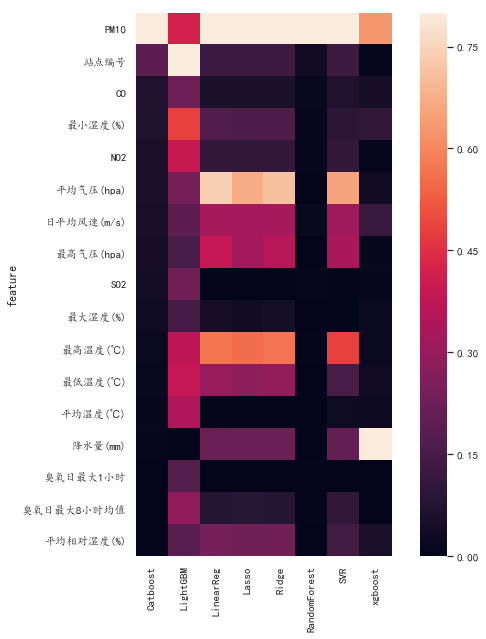

In [22]:
fea_scaler.index = fea["feature"]
plt.figure(figsize = (10,10))
fea_scaler.columns = models_name[1:-1]
sns.set(font="KaiTi")
sns.heatmap(fea_scaler,square = True,  vmax=0.8) 

In [23]:
from sklearn import metrics
loss = {"Explained variance score":[], "Mean absolute error":[], "Mean squared error":[], 
        "Median absolute error":[], "r2":[]}
loss_func = [metrics.explained_variance_score, metrics.mean_absolute_error, metrics.mean_squared_error,
            metrics.median_absolute_error, metrics.r2_score]
for model,model_name in zip(models,models_name[1:]):
    if model_name in ["Catboost", "LightGBM", "RandomForest", "xgboost"]:
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)
    for lf,lsn in zip(loss_func, loss):
        loss[lsn].append(lf(y_test, y_pred))
loss = pd.DataFrame(loss)
loss.index = models_name[1:]
loss.sort_values(by='r2')

,Explained variance score,Mean absolute error,Mean squared error,Median absolute error,r2
LinearReg,0.786955,0.205246,0.073936,0.158091,0.786951
Ridge,0.787133,0.205113,0.073874,0.159424,0.787129
Lasso,0.787439,0.204866,0.073767,0.159710,0.787436
SVR,0.791471,0.201145,0.072531,0.148955,0.790998
NN,0.884008,0.157118,0.040320,0.137098,0.883817
RandomForest,0.912506,0.133984,0.030379,0.106606,0.912462
LightGBM,0.945777,0.102938,0.018817,0.079441,0.945777
Catboost,0.951584,0.097354,0.016803,0.076391,0.951582
xgboost,0.958123,0.090106,0.014609,0.068715,0.957905
